### WALMART
### Description projet
Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

The project is divided into four parts:

`01-EDA` : make an EDA and all the necessary preprocessings to prepare data for machine learning <br>
`02-cleaning-models`: Preprocessing to prepare the data for the model and train a linear regression model (baseline) and regularization<br>


In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from pandas_profiling import ProfileReport

In [2]:
%matplotlib inline

In [3]:
col_types = {'Store': np.int8,
             'Date':str,
             'Weekly_Sales':np.float64,
             'Holiday_Flag':np.float16,
             'Temperature':np.float16,
             'Fuel_Price':np.float16,
             'CPI':np.float16,
            'Unemployment':np.float16,}
data = pd.read_csv('./../data/raw/Walmart_Store_sales.csv', date_parser=True, usecols=col_types.keys(), dtype=col_types)#, usecols=col_types.keys(), dtype=col_types)

### Describe data

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

Holidays in USA

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

*source: Kaggle*

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    int8   
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float16
 4   Temperature   132 non-null    float16
 5   Fuel_Price    136 non-null    float16
 6   CPI           138 non-null    float16
 7   Unemployment  135 non-null    float16
dtypes: float16(5), float64(1), int8(1), object(1)
memory usage: 4.1+ KB


In [5]:
data.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6,18-02-2011,1572117.54,NaN,59.6250,3.044922,214.750,6.859375
1,13,25-03-2011,1807545.43,0.0,42.3750,3.435547,128.625,7.468750
2,17,27-07-2012,NaN,0.0,NaN,NaN,130.750,5.937500
3,11,NaN,1244390.03,0.0,84.5625,NaN,214.500,7.347656
4,6,28-05-2010,1644470.66,0.0,78.8750,2.759766,212.375,7.093750


- The dataset has 5 numerical variables: <br>
      Weekly_Sales,  Temperature, Fuel_Price, CPI, Unemployment
- 3 categorical variables: Holiday_Flag, Store, Date <br>


In [35]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.00000,135.000000
mean,9.866667,1.249536e+06,0.079712,61.406250,3.322266,180.00000,7.601562
std,6.231191,6.474630e+05,0.271973,18.375000,0.478271,40.28125,1.577148
min,1.000000,2.689290e+05,0.000000,18.796875,2.513672,126.12500,5.144531
25%,4.000000,6.050757e+05,0.000000,45.593750,2.851562,132.00000,6.597656
50%,9.000000,1.261424e+06,0.000000,63.000000,3.451172,198.00000,7.468750
75%,15.750000,1.806386e+06,0.000000,76.312500,3.707031,214.87500,8.148438
max,20.000000,2.771397e+06,1.000000,91.625000,4.191406,227.00000,14.312500


## <b> Count missing values

In [6]:
def missing_values(data):
    return pd.concat([data.isna().sum(), 
        np.round(data.isna().sum()*100/data.shape[0])], 
        axis=1).rename({0:'count_missing', 1:'%_missing'}, axis=1)

In [7]:
missing_values(data)

,count_missing,%_missing
Store,0,0.0
Date,18,12.0
Weekly_Sales,14,9.0
Holiday_Flag,12,8.0
Temperature,18,12.0
Fuel_Price,14,9.0
CPI,12,8.0
Unemployment,15,10.0


> Note: For 150 rows, there are 12% of empty Dates and 9% without Weekly_Sales

data = data.dropna(subset=['Weekly_Sales', 'Date'], axis=0)

### Searching for correlations

At first glance to the heatmap and the graphs, there is no varible with strong correlation with Weekly_Sales

In [8]:
#Create a copy to make transformations
sales = data.copy()

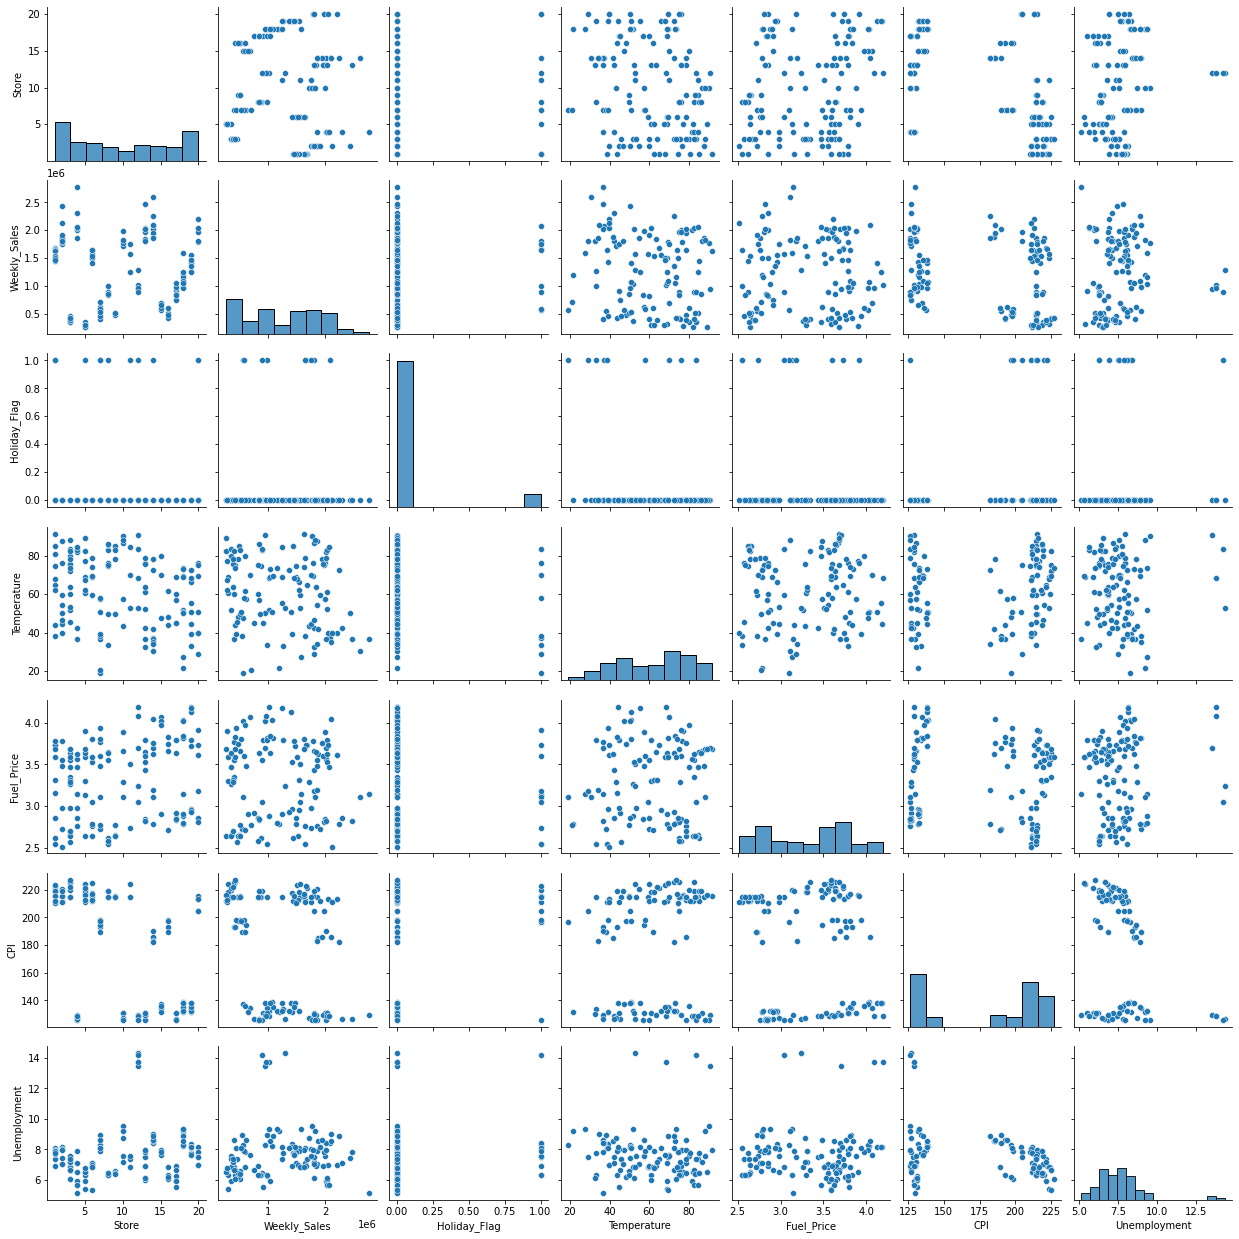

In [9]:
sns.pairplot(data=sales)

> 1st impression: Since Fuel_Price and Unemployment are given per Region, it seems that Stores are in 3 regions mainly

In [10]:
corr_matrix = sales.corr()

In [11]:
corr_matrix['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales    1.000000
Store           0.115964
Unemployment    0.055286
Holiday_Flag    0.037037
Fuel_Price     -0.019117
Temperature    -0.166003
CPI            -0.287155
Name: Weekly_Sales, dtype: float64

The weekly_sales seem to go up when the CPI goes down from 180 to 225

<AxesSubplot:>

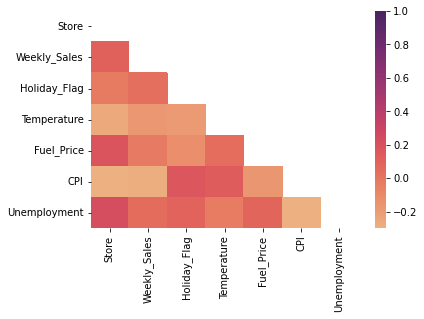

In [32]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=corr_matrix, mask=mask, vmin=-0.3, vmax=1, cmap="flare")

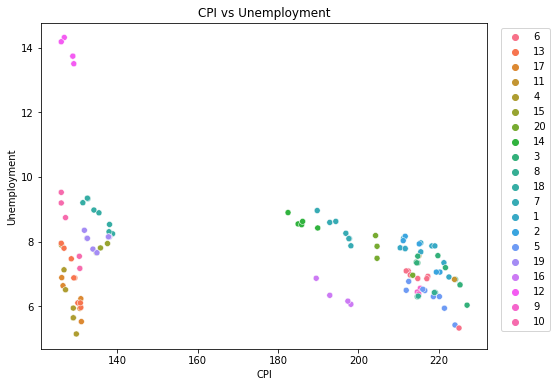

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=sales, x='CPI', y='Unemployment', hue='Store')
plt.title("CPI vs Unemployment")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')#bbox_to_anchor allows to place the legend outside the plot

- 1st region: CPI less than 140 and Unemployment > 12
- 2nd region: CPI less than 140 and Unemployment less than 10
- 3d region: CPI > 180

In [13]:
region1 = (sales['CPI'] > 180)
region2 = (sales['CPI'] < 140) & (sales['Unemployment'] < 10)
region3 = sales['Unemployment'] > 10

In [14]:
print('Region 1')
sales[region1]['Store'].value_counts().index

Region 1


Int64Index([3, 1, 5, 8, 2, 6, 7, 14, 20, 9, 16, 11], dtype='int64')

In [15]:
print('Region 2')
sales[region2]['Store'].value_counts().index

Region 2


Int64Index([19, 13, 18, 4, 10, 17, 15], dtype='int64')

In [16]:
print('Region 3')
sales[region3]['Store'].value_counts().index

Region 3


Int64Index([12], dtype='int64')

### Format some variables: Date, Weekly_Sales

#### Weekly_Sales

In [17]:
#Divide Weekly_Sales by 1M
sales = sales.astype({'Store':'str'})
sales['Weekly_Sales'] = sales['Weekly_Sales']/1000000

#### New features from Date

In [18]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Year']=sales['Date'].dt.year 
sales['Month']=sales['Date'].dt.month
sales['dayOfWeek']=sales['Date'].dt.dayofweek
sales['weekday']=sales['Date'].dt.strftime("%A")
sales['week']=sales['Date'].dt.isocalendar().week

sales = sales.astype({'Month':'Int16'})
sales = sales.astype({'Year':'Int16'})
sales = sales.astype({'dayOfWeek':'Int16'})
sales = sales.astype({'week':'Int16'})

sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,dayOfWeek,weekday,week
0,6,2011-02-18,1.572118,NaN,59.6250,3.044922,214.750,6.859375,2011,2,4,Friday,7
1,13,2011-03-25,1.807545,0.0,42.3750,3.435547,128.625,7.468750,2011,3,4,Friday,12
2,17,2012-07-27,NaN,0.0,NaN,NaN,130.750,5.937500,2012,7,4,Friday,30
3,11,NaT,1.244390,0.0,84.5625,NaN,214.500,7.347656,<NA>,<NA>,<NA>,NaN,<NA>
4,6,2010-05-28,1.644471,0.0,78.8750,2.759766,212.375,7.093750,2010,5,4,Friday,21


### Value counts: Store and weekday

In [19]:
for col in sales.select_dtypes(include='object'):
    print(f'{col}: {len(sales[col].value_counts())} different values')
    print(sales[col].value_counts())

Store: 20 different values
3     15
1     11
18    10
19     9
13     9
5      9
14     9
17     8
8      8
2      8
7      8
4      7
6      7
20     7
12     5
10     5
15     4
9      4
16     4
11     3
Name: Store, dtype: int64
weekday: 6 different values
Friday      92
Tuesday     10
Sunday      10
Thursday     9
Monday       6
Saturday     5
Name: weekday, dtype: int64


profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_widgets()

## Weeks with holidays

In [56]:
select_cols = ['Store','Date','Year','Month', 'week','Holiday_Flag', 'Weekly_Sales']
filter_holidays = (sales['Holiday_Flag'] == 1) & ~(sales['Date'].isna())
sales.loc[filter_holidays][select_cols].sort_values('Date')

,Store,Date,Year,Month,week,Holiday_Flag,Weekly_Sales
135,12,2010-10-09,2010,10,40,1.0,0.903119
114,11,2010-11-26,2010,11,47,1.0,1.757243
44,1,2010-12-02,2010,12,48,1.0,1.641957
107,8,2010-12-02,2010,12,48,1.0,0.994801
110,20,2010-12-31,2010,12,52,1.0,1.799738
31,5,2011-12-30,2011,12,52,1.0,NaN
71,20,2012-07-09,2012,7,28,1.0,NaN
122,7,2012-07-09,2012,7,28,1.0,0.597877
32,7,2012-10-02,2012,10,40,1.0,0.563461
33,14,2012-10-02,2012,10,40,1.0,2.077256


In [70]:
print(f'Weeks with holidays')
holiday_weeks = sales[filter_holidays][['Year','week']].drop_duplicates().sort_values(by=['Year','week'])
#holiday_weeks = np.unique(holiday_weeks)
holiday_weeks

Weeks with holidays


,Year,week
135,2010,40
114,2010,47
44,2010,48
110,2010,52
31,2011,52
71,2012,28
32,2012,40


#### Known weeks with holidays in USA to complete the missing Holiday_Flags

In [76]:
holidays = ['12-Feb-10', '11-Feb-11', '10-Feb-12', #'8-Feb-13', # Super Bowl
 '10-Sep-10', '9-Sep-11', '7-Sep-12', #'6-Sep-13', # Labor Day
 '26-Nov-10', '25-Nov-11', '23-Nov-12', #'29-Nov-13', #Thanksgiving
 '31-Dec-10', '30-Dec-11', '28-Dec-12', #'27-Dec-13', #Christmas
  '04-Jul-10', '04-Jul-11', '04-Jul-12'#, '04-Jul-13'
           ] 

holidays_df = pd.DataFrame({'Holiday':holidays})
holidays_df['Holiday_Date'] = pd.to_datetime(holidays_df['Holiday'])
holidays_df['Year'] = holidays_df['Holiday_Date'].dt.year
holidays_df['Month'] = holidays_df['Holiday_Date'].dt.month
holidays_df['Weekday'] = holidays_df['Holiday_Date'].dt.strftime("%A")
holidays_df['week'] = holidays_df['Holiday_Date'].dt.isocalendar().week


In [77]:
holidays_df.sort_values(by=['Year', 'week'])

,Holiday,Holiday_Date,Year,Month,Weekday,week
0,12-Feb-10,2010-02-12,2010,2,Friday,6
12,04-Jul-10,2010-07-04,2010,7,Sunday,26
3,10-Sep-10,2010-09-10,2010,9,Friday,36
6,26-Nov-10,2010-11-26,2010,11,Friday,47
9,31-Dec-10,2010-12-31,2010,12,Friday,52
1,11-Feb-11,2011-02-11,2011,2,Friday,6
13,04-Jul-11,2011-07-04,2011,7,Monday,27
4,9-Sep-11,2011-09-09,2011,9,Friday,36
7,25-Nov-11,2011-11-25,2011,11,Friday,47
10,30-Dec-11,2011-12-30,2011,12,Friday,52


## <b> Weeks with data per Store

In [79]:
sales['Year'].value_counts()

2010    54
2011    43
2012    35
Name: Year, dtype: Int64

In [94]:
total_sales = sales.groupby(['Store'])['Weekly_Sales'].sum().sort_values(ascending=False)
total_sales

Store
14    18.835906
13    17.975119
2     15.544269
1     14.062575
4     13.042554
18    11.404365
19    11.204922
20     9.811922
6      9.306741
10     9.110529
17     6.241242
8      5.332525
12     5.140125
3      4.836659
11     4.571240
7      4.473040
15     2.534322
5      2.419997
16     2.061271
9      2.027550
Name: Weekly_Sales, dtype: float64

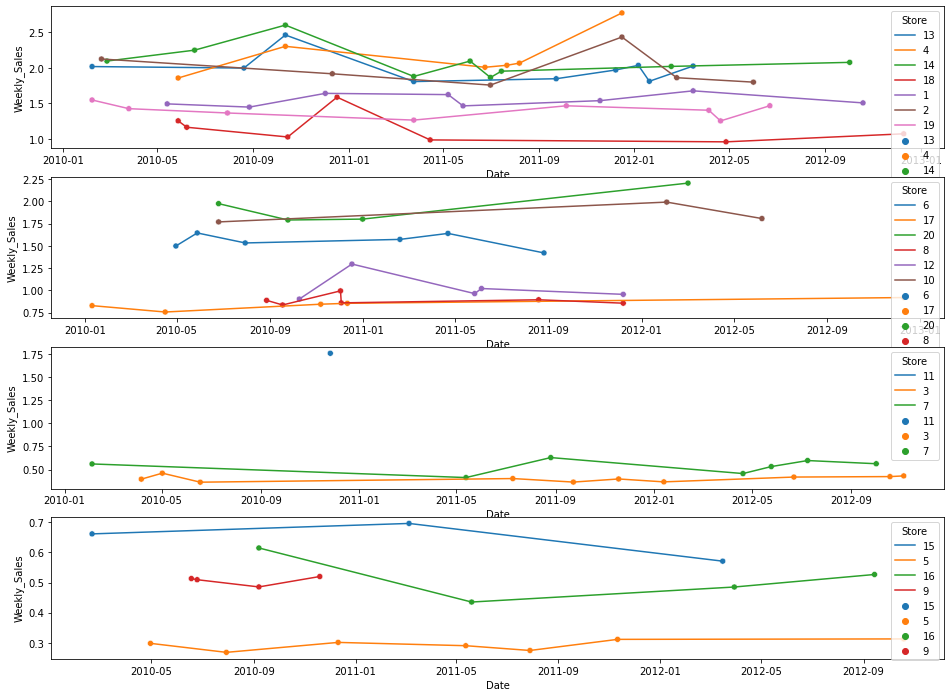

In [93]:
stores = [['14', '13', '2', '1', '4', '18', '19'],
         ['20', '6', '10', '17', '8', '12'],
         ['3', '11', '7'],
         ['15', '5', '16', '9']]
fig, axes = plt.subplots(4,1,figsize=(16,12))
for i in range(4):
    sns.scatterplot(data=sales[sales['Store'].isin(stores[i])], x='Date', y='Weekly_Sales', hue='Store', ax=axes[i])
    sns.lineplot(data=sales[sales['Store'].isin(stores[i])], x='Date', y='Weekly_Sales', hue='Store', ax=axes[i])

#### Missing values per Store

In [106]:
print(f'Stores with missing data per year')
year = ['2010', '2011', '2012']
stores = ['1','2', '3', '4','5','6', '7', '8','9','10', '11', '12','13','14', '15', '16','17','18', '19', '20']
sales_store_year = sales.groupby(['Year','Store'])['Weekly_Sales'].sum().reset_index().pivot('Store', 'Year', 'Weekly_Sales')
sales_store_year

Stores with missing data per year


Year,2010,2011,2012
Store,,,
1,4.585352,4.629914,3.185542
10,1.768172,NaN,3.796371
11,1.757243,NaN,NaN
12,2.198724,2.941401,NaN
13,6.477181,5.625318,5.872620
14,6.944756,7.793342,4.097807
15,0.660839,0.695396,0.570611
16,0.614253,0.435397,1.011621
17,3.287658,NaN,0.919878


In [97]:
print('Number of reported weeks with data in stores')
sales.groupby('Store')['Date'].count().sort_values(ascending=False)

Number of reported weeks with data in stores


Store
3     13
1     10
13     9
14     9
19     9
5      8
8      8
18     7
4      7
6      7
7      7
17     6
2      6
20     6
12     5
16     4
9      4
15     3
10     3
11     1
Name: Date, dtype: int64

> Store 11 has only one valid entry 

> Stores 15 and 10 have only 3 valid entries with non-empty date

In [100]:
print(f'Example: Store 10 only has 3 rows with a Date and 2 rows with empty date')
sales[sales['Store'].isin(['10', '15'])].sort_values(by='Store')

Example: Store 10 only has 3 rows with a Date and 2 rows with empty date


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,dayOfWeek,weekday,week
54,10,2012-06-07,1.806000,0.0,86.87500,3.666016,130.7500,7.171875,2012,6,3,Thursday,23
61,10,2012-02-03,1.990371,0.0,57.62500,3.882812,130.6250,7.546875,2012,2,4,Friday,5
65,10,NaT,1.714310,NaN,43.43750,3.287109,127.1875,8.742188,<NA>,<NA>,<NA>,NaN,<NA>
98,10,2010-06-25,1.768172,0.0,90.31250,NaN,126.1250,9.523438,2010,6,4,Friday,25
137,10,NaT,1.831676,0.0,88.43750,3.111328,126.1250,9.195312,<NA>,<NA>,<NA>,NaN,<NA>
6,15,2011-03-06,0.695396,0.0,69.81250,4.070312,134.8750,7.656250,2011,3,6,Sunday,9
76,15,2012-03-16,0.570611,0.0,47.40625,4.019531,137.6250,7.941406,2012,3,4,Friday,11
83,15,NaT,0.607475,0.0,80.00000,3.972656,135.8750,7.804688,<NA>,<NA>,<NA>,NaN,<NA>
115,15,2010-02-19,0.660839,0.0,NaN,2.908203,131.6250,NaN,2010,2,4,Friday,7


In [101]:
#sales[sales['Store'] == '3.0'].sort_values(by='week')
print(f'Number of non-empty rows and holiday flags per week ')
sales.groupby('week')[['Weekly_Sales','Holiday_Flag']].agg({'Weekly_Sales':'count', 'Holiday_Flag':'sum'}) \
.rename({'Weekly_Sales':'Count Weekly_Sales', 'Holiday_Flag':'Count Holiday_Flag'})

Number of non-empty rows and holiday flags per week 


,Weekly_Sales,Holiday_Flag
week,,
1,2,0.0
2,1,0.0
3,1,0.0
5,4,0.0
7,4,0.0
8,2,0.0
9,2,0.0
10,0,0.0
11,3,0.0


Number of stores:20


Index(['14', '13', '2', '1', '4', '18', '19', '20', '6', '10', '17', '8', '12',
       '3', '11', '7', '15', '5', '16', '9'],
      dtype='object', name='Store')

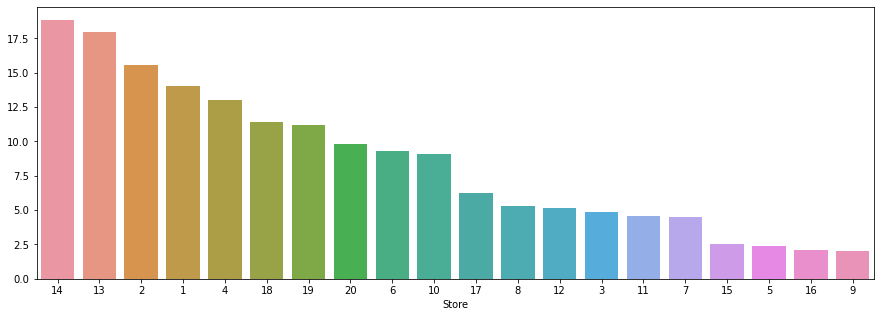

In [108]:
plt.figure(figsize=(15, 5))
sns.barplot(x=sales_per_store.index, y=sales_per_store.values)

print(f'Number of stores:{len(sales_per_store.index)}')

sales_per_store.index

The stores 14, 13, 2, 1, 4 have the top sales

In [109]:
def sales_per_month(data):
    sales_month = data.groupby(['Month','Year'])['Weekly_Sales'].agg('sum').to_frame().reset_index()
    return sales_month

In [110]:
def sales_per_year(data):
    sales_per_year = data.groupby(['Year'])['Weekly_Sales'].sum().to_frame().reset_index()
    return sales_per_year

Text(0.5, 1.0, 'Year sales per month')

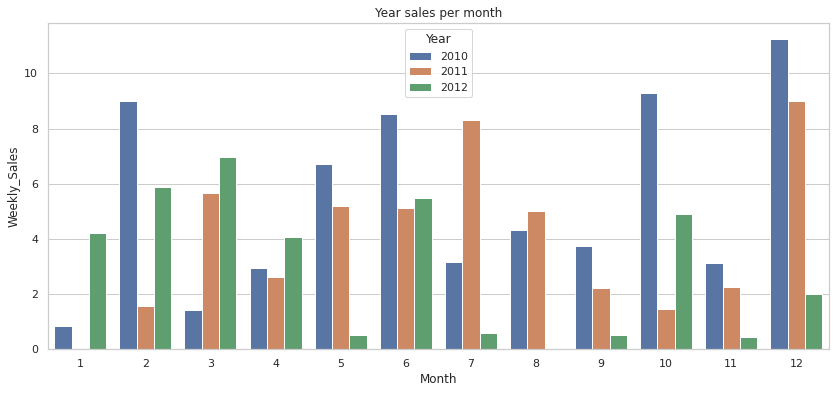

In [111]:
#plt.figure(figsize=(15, 5))
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(figsize=(14, 6))
sns.barplot(data=sales_per_month(sales), x='Month', y='Weekly_Sales', hue='Year',ax=axes)
axes.set_title('Year sales per month')

#sns.barplot(data=sales, x='Date', y='Weekly_Sales')

Text(0.5, 1.0, 'Year sales')

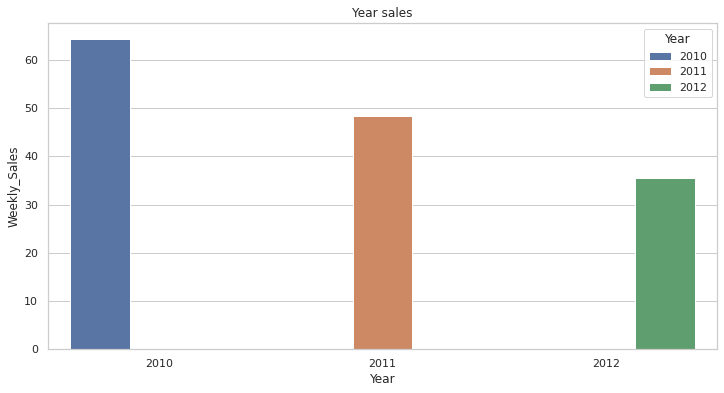

In [114]:
fig, axes = plt.subplots(figsize=(12, 6))
sns.barplot(data=sales_per_year(sales), x='Year', y='Weekly_Sales', hue='Year',ax=axes)
axes.set_title('Year sales')

### Missing values per Store

In [115]:
missing_values(sales[['Store', 'Year', 'Weekly_Sales']])

,count_missing,%_missing
Store,0,0.0
Year,18,12.0
Weekly_Sales,14,9.0


In [118]:
sales_per_month(sales).sort_values(by=['Year','Month'])

,Month,Year,Weekly_Sales
0,1,2010,0.829207
2,2,2010,9.009360
5,3,2010,1.427023
8,4,2010,2.951486
11,5,2010,6.714161
14,6,2010,8.542486
17,7,2010,3.167634
20,8,2010,4.335357
22,9,2010,3.726038
25,10,2010,9.297230


In [119]:
filter_holiday = data['Holiday_Flag'] == 1
sales[filter_holiday]
#sns.barplot(x=sales_per_month(sales[filter_holiday]).index, y=sales_per_month(sales[filter_holiday]).values)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,dayOfWeek,weekday,week
31,5,2011-12-30,NaN,1.0,NaN,3.128906,220.125,6.300781,2011,12,4,Friday,52
32,7,2012-10-02,0.563461,1.0,18.796875,3.103516,196.875,8.257812,2012,10,1,Tuesday,40
33,14,2012-10-02,2.077256,1.0,37.000000,NaN,NaN,8.421875,2012,10,1,Tuesday,40
42,1,NaT,1.661767,1.0,NaN,3.730469,222.500,6.906250,<NA>,<NA>,<NA>,NaN,<NA>
44,1,2010-12-02,1.641957,1.0,38.500000,2.548828,211.250,8.109375,2010,12,3,Thursday,48
71,20,2012-07-09,NaN,1.0,76.375000,3.910156,215.250,NaN,2012,7,0,Monday,28
107,8,2010-12-02,0.994801,1.0,33.343750,2.548828,214.625,6.300781,2010,12,3,Thursday,48
110,20,2010-12-31,1.799738,1.0,28.843750,3.179688,204.625,7.484375,2010,12,4,Friday,52
114,11,2010-11-26,1.757243,1.0,69.875000,2.734375,215.000,7.562500,2010,11,4,Friday,47
122,7,2012-07-09,0.597877,1.0,57.843750,3.595703,198.125,7.871094,2012,7,0,Monday,28


## Visualize distributions

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.2)

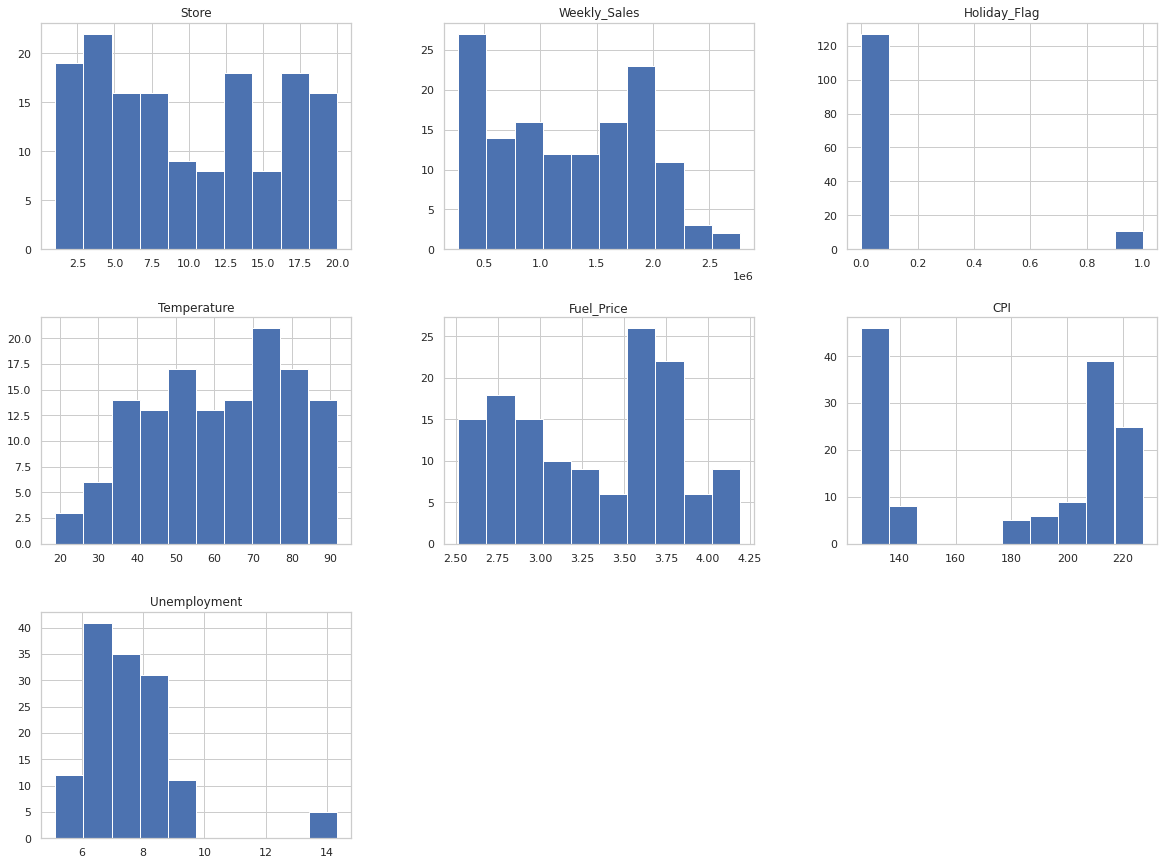

In [121]:
data.hist(figsize=(20,15))
plt.show()

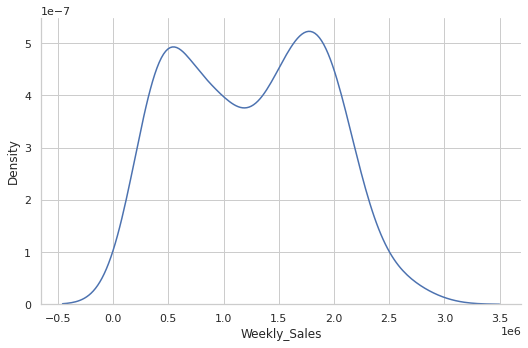

In [120]:
sns.displot(x='Weekly_Sales', kind='kde', data=data, aspect=1.5 )